# A differentiable atmosphere
One of the most relevant source of uncertainty in the propagation of satellite orbits is the atmospheric drag. 
The drag acceleration a satellite is subject to, and mainly responsible for its [orbital decay](https://en.wikipedia.org/wiki/Orbital_decay), depends mainly on the atmospheric density encountered, which is very uncertain.

Empirical atmospheric model  models such as the [NRLMSISE00](https://en.wikipedia.org/wiki/NRLMSISE-00) provide a precise description of the past
values of atmospheric density and are often used as a standard in satellite re-entry calculations.

For the purpose of the simulations of entire orbital environments for long time the direct use on the full [NRLMSISE00](https://en.wikipedia.org/wiki/NRLMSISE-00) would
be inefficient and not necessary. It is of value, therefore, to create a simplified model starting from [NRLMSISE00](https://en.wikipedia.org/wiki/NRLMSISE-00), and one that is differentiable and hence can be used in conjunction to [Taylor integration](https://bluescarni.github.io/heyoka/tut_taylor_method.html) techniques.

In the following code we show some python code using the [NRLMSISE00](https://en.wikipedia.org/wiki/NRLMSISE-00) atmospheric model to derive a simple and differentiable profile to be used in such simulations. Note that the differentiability is a prerequisite in the description of the dynamics for cascade and hence [NRLMSISE00](https://en.wikipedia.org/wiki/NRLMSISE-00) could be used directly even if one would be willing to pay the connected inefficiencies.

Let us start with some imports:

In [1]:
# Core imports
import numpy as np
import pickle as pkl
import pygmo as pg

# NRLMSISE00 atmospheric model
from datetime import datetime
from nrlmsise00.dataset import msise_4d

# Plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  

/home/dario/.local/lib/python3.10/site-packages/nrlmsise00/dataset/__init__.py:27: UserWarning: The xarray 4d interface is experimental.
  warn("The xarray 4d interface is experimental.", UserWarning)


We first use and plot the atmospheric density profile at the equator (latitude is 0) for some longitude 42 and up to 1000km.

Text(0, 0.5, 'Density [kg/m^]')

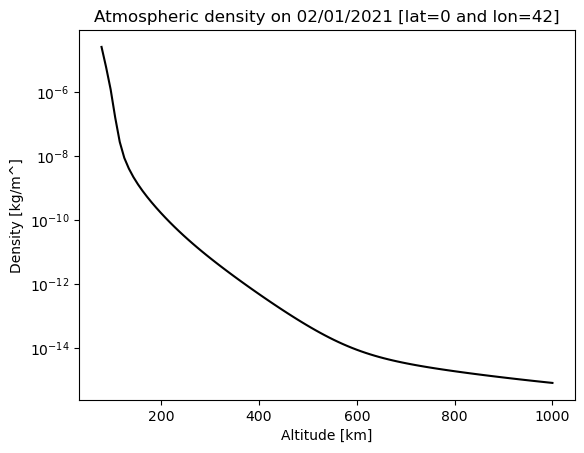

In [2]:
# This is the grid on the altitude
altitude = np.linspace(78, 1000, 100)
lat = 0
lon = 42
ds = msise_4d(datetime(2021, 2, 1, 0,0, 0), altitude, lat, lon)
density_nrl = ds["rho"].data.reshape(100,) * 1000 # now in km/m^2
plt.figure()
plt.semilogy(altitude, density_nrl, 'k')
plt.title("Atmospheric density on 02/01/2021 [lat="+str(lat)+" and lon="+str(lon)+"]")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^]")

We are now going to assume that the atmospheric density will not vary with longitude nor with latitude and that it has the following shape:

$$
\rho(h) = \sum_i\alpha_i\exp(-\beta_i(h-\gamma_i))
$$

where $\alpha_i, \beta_i$ and $\gamma_i$ are various constant to be determined as to fit well the data from the NRLMSISE00 model shown in the plot above. Note that the form 
of the function choosen as a limit of zero as h goes to infinity, a desirable behaviour for the use in a numerical simulation which cannot guarantee the objects ware in a specific shell.

We will make use of [pygmo](https://esa.github.io/pygmo2/) to solve the problem of finding the values of $\alpha_i, \beta_i$ and $\gamma_i$ fitting to the numerical data. The User Defined Problem (UDP) in pygmo is then coded:

In [3]:
class fitting_NRLMSISE00:
    """THis UDP will find a fit for X,Y data to the shape a_i*exp(-b_i*(h-g_i)), i=1..n
    """
    def __init__(self, X, Y, n=4):
        self.X = X
        self.Y = Y
        self.n = n
    def fitness(self,x):
        p1 = x[:self.n]
        p2 = x[self.n:2*self.n]
        p3 = x[2*self.n:]
        Y_pred = self._fitting_function(self.X,p1,p2, p3)
        return [np.mean(np.abs(np.log10(self.Y)-np.log10(Y_pred)))]
    def _fitting_function(self, x, p1,p2, p3):
        retval = 0.
        for alpha,beta, gamma in zip(p1,p2, p3):
            retval += alpha*np.exp(-(x-gamma)*beta)
        return retval
    def get_bounds(self):
        lb = [0]*self.n*3
        ub = [1.]*self.n*3
        ub[self.n*2:] = [1000]*self.n
        return (lb, ub)

We then instantiate the pygmo problem using NRLMSISE00 data as target and use 4 terms in the expression, hence 12 constants.

In [4]:
udp = fitting_NRLMSISE00(altitude, density_nrl, n=4)
prob = pg.problem(udp)

As algorithm we make use od the self-adaptive version of differential evolution, and use a random initial population.

In [5]:
uda = pg.sade(50, memory=True)
algo = pg.algorithm(uda)
pop  =pg.population(prob, 20)

/tmp/ipykernel_2562404/264072196.py:17: RuntimeWarning: overflow encountered in exp
  retval += alpha*np.exp(-(x-gamma)*beta)


We now evolve the population ...

In [6]:
for i in range(500):
    pop = algo.evolve(pop)

/tmp/ipykernel_2562404/264072196.py:17: RuntimeWarning: overflow encountered in exp
  retval += alpha*np.exp(-(x-gamma)*beta)
/tmp/ipykernel_2562404/264072196.py:13: RuntimeWarning: divide by zero encountered in log10
  return [np.mean(np.abs(np.log10(self.Y)-np.log10(Y_pred)))]


... and plot the result

In [7]:
def compute_density(h_in_km, best_x):
    """
    returns the atmosheric density in kg.m^3 from the fitted parameters
    """
    p1 = np.array(best_x[:4])
    p2 = np.array(best_x[4:8])
    p3 = np.array(best_x[8:])
    retval = 0.
    for alpha,beta, gamma in zip(p1,p2, p3):
        retval += alpha*np.exp(-(h_in_km-gamma)*beta)
    return retval

Text(0, 0.5, 'Density [kg/m^]')

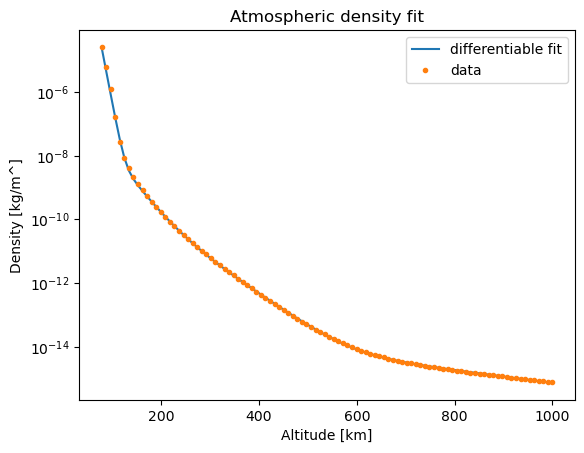

In [8]:
plt.figure()
plt.semilogy(altitude, compute_density(altitude, pop.champion_x), label ='differentiable fit')
plt.semilogy(altitude, density_nrl, '.', label='data')
plt.legend()
plt.title("Atmospheric density fit")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^]")

One may, occasionally, need to repeat the evolution as the fit may be not satisfactory. In the case plotted above we can be satisfied, and hence save the results in a pickled file.

In [9]:
with open("data/best_fit_density.pk", "wb") as file:
    pkl.dump(pop.champion_x, file)